In [1]:
import numpy as np
import os 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
from scipy import stats
import scipy.stats
import seaborn as sns
import tensorflow as tf
import scipy.io
from tqdm import tqdm
import pickle
import time
from itertools import accumulate
from collections import Counter
from sklearn.preprocessing import MinMaxScaler


import encoding_GLM as glm #Import the encoding_GLM package 

In [2]:
#CPU and GPU checks:

print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Wrapper Functions

In [57]:
def get_data_from_each_CV_fold(train_directory, test_directory, fold):
    '''
        function to locate and arrange the train and test datasets prior to training the GLM encoding model 
        
        inputs:
        train_directory: location of the training datasets 
        test_directory: location of the testing datasets 
        fold: cross validation fold for the specified dataset 
        
        outputs:
        X_train, Y_train: Variables + neural data for training set 
        X_test, Y_test: Variables + neural data for testing set 
        count_of_values: # and position of unique variables for fitting 
        IDS_for_count_of_values: names of the unique variables for fitting - helps for B-weight analysis 
    '''
    directory_train = train_directory.format(fold)
    os.chdir(directory_train)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    #response_matrix[response_matrix > 0.05] = 1 #binarizes response 

    X_train = behav_matrix
    Y_train = response_matrix
    
    behav_IDS = []
    for trial in list(range(behav_ids['behav_big_matrix_ids'][0].shape[0])):
        behav_IDS.append(behav_ids['behav_big_matrix_ids'][0][trial][0])

    # Count the occurrences of each element in the list
    counter = Counter(behav_IDS)

    # Get the unique values
    unique_values = list(counter.keys())

    # Get the count of each unique value
    count_of_values = list(counter.values())

    IDS_index = np.array(list(accumulate(count_of_values)))-1
    IDS_for_count_of_values = []
    for index in IDS_index:
        IDS_for_count_of_values.append(behav_IDS[index])
        
    directory_test = test_directory.format(fold)
    os.chdir(directory_test)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    #response_matrix[response_matrix > 0.05] = 1

    X_test = behav_matrix
    Y_test = response_matrix
    
    # Clean up design matrix and z-score along sample dimension
    X_train = X_train.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_train = 10 * Y_train.T

    X_test = X_test.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_test = 10 * Y_test.T
    
    return X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values

def train_model_on_cv_fold(X_train, Y_train, count_of_values, activation, loss_type, regularization, l1_ratio):
    '''
        function to train the GLM encoding model for an entire fold on local CPU 
        
        inputs:
        X_train, Y_train: Variables + neural data for training set 
        X_test, Y_test: Variables + neural data for testing set 
        count_of_values: # and position of unique variables for fitting 
        activation: {'linear', 'exp', 'sigmoid', 'relu', 'softplus'}, default = 'exp'
        loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'
        regularization: {'elastic_net', 'group_lasso'}, default = 'elastic_net'
        l1_ratio: L1 ratio for elastic_net regularization (l1_ratio = 1. is Lasso, l1_ratio = 0. is ridge), default = 0.
        outputs:
        model: trained model results (as tensor matrix)
    '''
    # Reset keras states
    tf.keras.backend.clear_session()

    model = glm.GLM(activation = activation, loss_type = loss_type, 
                    regularization = regularization, lambda_series = 10.0 ** np.linspace(-1, -6, 11), 
                    l1_ratio = l1_ratio, smooth_strength = 0., 
                    optimizer = 'adam', learning_rate = 1e-3)
    
    model.fit(X_train, Y_train, feature_group_size = count_of_values, verbose = False) 
    
    return model

def train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values, activation, loss_type, regularization, l1_ratio):
    '''
        function to train the GLM encoding model for an entire fold on local GPU - significantly faster  
        
        inputs:
        X_train, Y_train: Variables + neural data for training set 
        X_test, Y_test: Variables + neural data for testing set 
        count_of_values: # and position of unique variables for fitting 
        activation: {'linear', 'exp', 'sigmoid', 'relu', 'softplus'}, default = 'exp'
        loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'
        regularization: {'elastic_net', 'group_lasso'}, default = 'elastic_net'
        l1_ratio: L1 ratio for elastic_net regularization (l1_ratio = 1. is Lasso, l1_ratio = 0. is ridge), default = 0.
        outputs:
        model: trained model results (as tensor matrix)
    '''
    # Ensure the function runs on GPU
    with tf.device('/GPU:0'):
        # Reset keras states
        tf.keras.backend.clear_session()

        model = glm.GLM(activation = activation, loss_type = loss_type, 
                        regularization = regularization, lambda_series = 10.0 ** np.linspace(-1, -8, 10), 
                        l1_ratio = l1_ratio, smooth_strength = 0., 
                        optimizer = 'adam', learning_rate = 1e-3)
        # Capture the start time
        start_time = time.time()
        
        # Fit the model
        model.fit(X_train, Y_train, feature_group_size=count_of_values, verbose=False) 
        
        # Capture the end time
        end_time = time.time()

    print(f"Time taken on GPU: {end_time - start_time:.4f} seconds")
    
    return model

## Fit the Model! 

In [58]:
# specify parameters 

activation, loss_type, regularization, l1_ratio = 'exp', 'poisson', 'elastic_net', .95

In [59]:
# Fit a model for all folds in a dataset:

data_directory = "/Volumes/Runyan5/Connie/ProcessedData/HA11-1R/2023-05-05/VR" 
save_directory = "/Volumes/Runyan5/Connie/ProcessedData/HA11-1R/2023-05-05/VR/results_GPU"

frac_dev_expl_all = []
for fold_number in list(range(0,1)): #can change this to fit however many folds you need 
    train_directory = data_directory + "/prepost trial cv 73 #{}".format(fold_number+1)
    test_directory = data_directory + "/prepost trial cv 73 #{}/test".format(fold_number+1)

    for i in tqdm(range(5)):
        [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                    test_directory,
                                                                                                                    fold_number+1)
    model_trained = train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values, activation, loss_type, regularization, l1_ratio)
    model_trained.select_model(X_test, Y_test, min_lambda = 0.0, make_fig = False)
    frac_dev_expl, dev_model, dev_null, dev_expl = model_trained.evaluate(X_test, Y_test, make_fig = False)
    B_weights = model_trained.selected_w 
    intercept_weight = model_trained.selected_w0
    y_pred = model_trained.predict(X_test)
    scaler = MinMaxScaler()
    scaler.fit(y_pred)
    transform_ypred = scaler.transform(y_pred)
    transform_ypred[transform_ypred < .05] = 0
    transform_ypred = transform_ypred * 10
    selec_lambda = model_trained.selected_lambda
    
    model_data = {
        'frac_dev_expl': frac_dev_expl,
        'dev_model': dev_model,
        'dev_null': dev_null, 
        'dev_expl': dev_expl, 
        'B_weights': B_weights,
        'intercept_weight': intercept_weight,
        'y_pred': transform_ypred,
        'selec_lambda': selec_lambda
    }
    
    os.chdir(train_directory)

    with open('model_data_a95_GPU.pkl', 'wb') as file:
        pickle.dump(model_data, file)
        
    frac_dev_expl_all.append(model_data['frac_dev_expl'])

frac_dev_expl_all_state1 = np.array(frac_dev_expl_all, dtype=object)

os.chdir(save_directory)
np.save('performance_a95_GPU.npy', frac_dev_expl_all_state1)
print(' - DONE')

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Time taken on GPU: 625.1673 seconds
Fraction deviance explained: mean = 0.0813, median = 0.0511
 - DONE


Fraction deviance explained = 0.18


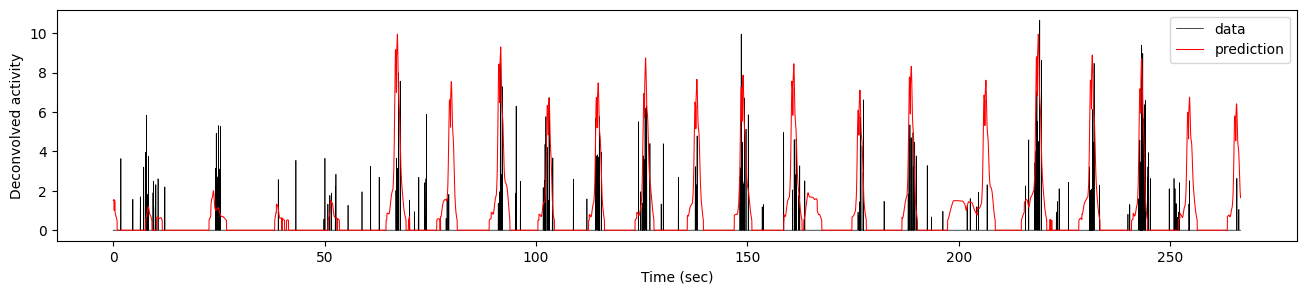

In [156]:
i_neuron = 23 # change this to examine different neurons
n_timepoints = 8000
sampling_freq_hz = 30
fig,ax = plt.subplots(figsize = (16,3))
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, Y_test[:n_timepoints, i_neuron], 'k', lw = 0.5, label = 'data')
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, transform_ypred[:n_timepoints, i_neuron], 'r', lw = 0.75, label = 'prediction')
plt.xlabel('Time (sec)')
plt.ylabel('Deconvolved activity')
plt.legend()
print(f'Fraction deviance explained = {frac_dev_expl[i_neuron]:.2f}')